In [6]:
import skimage
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams
from statsmodels.stats.weightstats import ttest_ind
from statannotations.Annotator import Annotator
rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

In [7]:
def get_ion(nucleus, soma, img_height = 1080, img_width = 1080):
    """
    Get intersection over nucleus. Similar to IoU, but divide by nucleus area
    instead of union, because we want a metric for nucleus containment within
    cytoplasm.
    """

    nucleus_img = np.zeros([img_height, img_width], dtype=bool)
    soma_img = np.zeros([img_height, img_width], dtype=bool)

    nucleus_img[nucleus[0]:nucleus[2], nucleus[1]:nucleus[3]] = True
    soma_img[soma[0]:soma[2], soma[1]:soma[3]] = True
    
    ion = (nucleus_img * soma_img).sum() / (nucleus_img).sum()
    return ion

def get_bounding_box(row):
    bb = [
        row['AreaShape_BoundingBoxMinimum_X'],
        row['AreaShape_BoundingBoxMinimum_Y'],
        row['AreaShape_BoundingBoxMaximum_X'],
        row['AreaShape_BoundingBoxMaximum_Y']
    ]
    return bb

In [8]:
class Plate():

    def __init__(self, data_dir, analysis_name):
        self.data_dir = data_dir
        self.analysis_name = analysis_name
        self._load_data()
        self._load_platemap()

    def _load_data(self):
            
        self.image_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'Image.csv'))
        self.soma_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'cytoplasm_outlines.csv'))
        self.nuclei_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'nuclei.csv'))
    
    def _load_platemap(self):
        self.platemap = pd.read_csv(self.data_dir / 'platemap.csv') 
    
    # def reindex_nuclei(self):
    #     nucleus_selection = []
    #     for img_number in self.nuclei_data['ImageNumber'].unique():

    #         nd = self.nuclei_data.query('ImageNumber==@img_number')
    #         sd = self.soma_data.query('ImageNumber==@img_number')

    #         for i_soma, sd_row in sd.iterrows():
    #             soma_bb = get_bounding_box(sd_row)
            
    #             ion_list = []
    #             for i_nucleus, nd_row in nd.iterrows():
    #                 nucleus_bb = get_bounding_box(nd_row)

    #                 ion_list.append(get_ion(soma_bb, nucleus_bb))

    #             best_nucleus = np.array(ion_list).argmax()
    #             nucleus_selection.append(nd.index[best_nucleus])

    #     self.nuclei_data = self.nuclei_data.loc[nucleus_selection]

    def reindex_nuclei(self):
        nucleus_selection = np.zeros(self.soma_data.shape[0])
        j_soma = 0
        for img_number in self.nuclei_data['ImageNumber'].unique():

            nd = self.nuclei_data.query('ImageNumber==@img_number')
            sd = self.soma_data.query('ImageNumber==@img_number')

            for i_soma, sd_row in sd.iterrows():
                soma_bb = get_bounding_box(sd_row)

                # Get centroid distances to sd soma for all nucleli
                nuclei_dist = np.sqrt(
                    (sd_row['AreaShape_Center_X'] - nd['AreaShape_Center_X']) ** 2 + \
                    (sd_row['AreaShape_Center_Y'] - nd['AreaShape_Center_Y']) ** 2  
                )
                # Get five closest nuclei
                closet_nuclei = nd.iloc[np.argsort(nuclei_dist)[:5]]

                ion_list = np.zeros(closet_nuclei.shape[0])
                i_nucleus = 0
                for j_nucleus, cn_row in closet_nuclei.iterrows():
                    nucleus_bb = get_bounding_box(cn_row)

                    ion_list[i_nucleus] = get_ion(soma_bb, nucleus_bb)
                    i_nucleus += 1

                best_nucleus = np.array(ion_list).argmax()
                # nucleus_selection[j_soma] = closet_nuclei.index[best_nucleus]
                nucleus_selection[j_soma] = closet_nuclei.index[0]
                j_soma += 1

        self.nuclei_data = self.nuclei_data.loc[nucleus_selection]
        self.nuclei_data.index = np.arange(self.nuclei_data.shape[0])

In [9]:
def calculate_ratio(plate, measurement):

    ratio_data = pd.DataFrame(index = plate.soma_data.index)

    # Set filename and well position
    ratio_data['FileName_TDP43'] = plate.soma_data['FileName_TDP43']
    ratio_data['well_position'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    ratio_data['row'] = ratio_data['FileName_TDP43'].apply(
    lambda fname : int(fname[1:3])
    )
    ratio_data['col'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : int(fname[4:6])
    )

    # Get mean TDP43 in nucleus
    ratio_data['TDP43_nucleus'] = (
        plate.nuclei_data[measurement] / 
        # 1
        plate.nuclei_data['AreaShape_Area']
        )

    # Get mean TDP43 in cytoplasm, subtracting out nucleus first
    ratio_data['TDP43_cytoplasm'] = (
        (plate.soma_data[measurement] - 
        plate.nuclei_data[measurement]) /
        # 1  
        (plate.soma_data['AreaShape_Area'] - 
        plate.nuclei_data['AreaShape_Area'])
    )

    # Get ratio of cytoplasm / nucleus
    ratio_data['TDP43_ratio'] = (
        ratio_data['TDP43_cytoplasm'] / 
        ratio_data['TDP43_nucleus']
    )
    return ratio_data


In [10]:
import copy
p = copy.deepcopy(plate)

NameError: name 'plate' is not defined

/tmp/ipykernel_3154/1533565658.py:62: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  closet_nuclei = nd.iloc[np.argsort(nuclei_dist)[:5]]
/tmp/ipykernel_3154/359680045.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_UNC13A vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=2.747e-01
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.407e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_C9ORF72 vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-7.496e-01
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.666e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_SCFD1 vs. 2_NT: t-test independent samples w

/home/ubuntu/miniconda3/envs/cell-imaging-2/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_RESP18 vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=4.118e-01
0_RESP18 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:nan t=nan


Text(884.3055555555555, 0.5, 'DIV25')

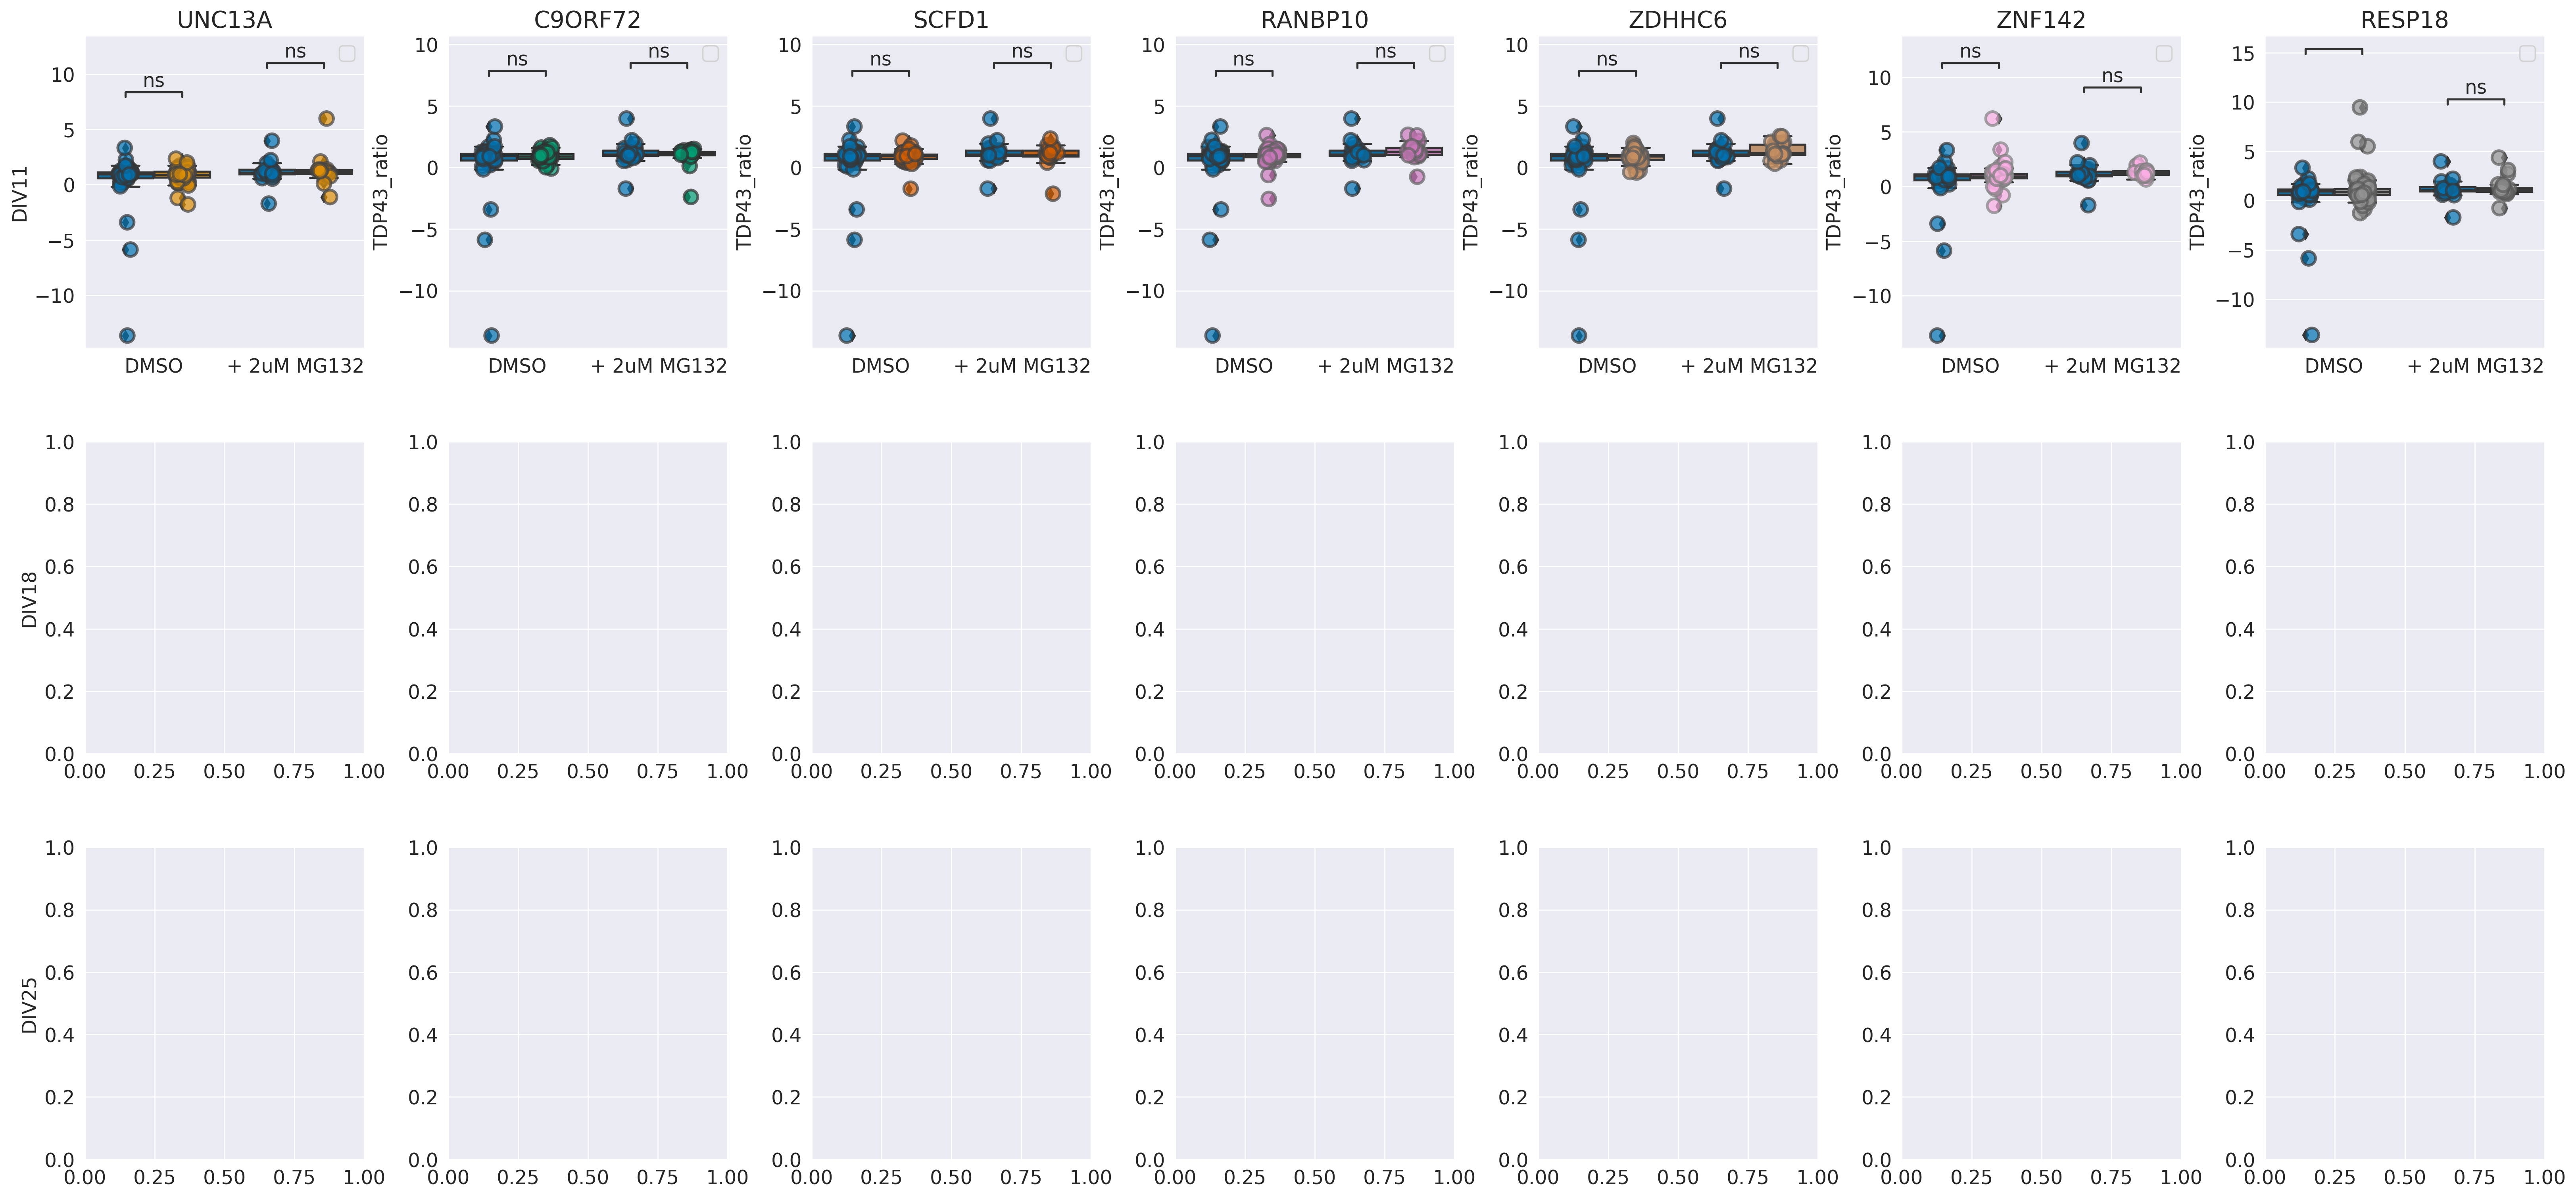

In [11]:
dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
    Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
    Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/')]
analysis_name = '2023-03-27_cellpose_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'
neg_con = 'NT'
concentration = "2"

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 15)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8], [0.4, 2]]
# crispr_mutants = ratio_data.query('crispr not in["empty", @neg_con]')['crispr'].unique()
crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
       'RESP18']
fig, axs = plt.subplots(3, len(crispr_mutants))

for i_exp, data_dir in enumerate([dirs[0]]):
    plate = Plate(data_dir, analysis_name)
    plate.reindex_nuclei()
    ratio_data = calculate_ratio(plate, measurement)
    ratio_data = ratio_data.merge(plate.platemap, on='well_position')
    ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
    # ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
    ratio_data = ratio_data.reset_index()
    # ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])

    # pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
    for i_crispr, crispr in enumerate(crispr_mutants):

        data = ratio_data.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')
        hue = 'crispr'
        x = 'concentration'
        y = 'TDP43_ratio'
        ax = axs[i_exp,i_crispr]
        crispr_color = sns.color_palette('colorblind')[i_crispr+1]
        hue_order = ['NT', crispr]
        sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color])
        sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
        ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
        ax.set_xlabel('')
        ax.legend([])
        ax.set_title(crispr)

        pairs = [(('0', neg_con), ('0', crispr)), ((concentration, neg_con), (concentration, crispr))]
        annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
        annot.apply_test(num_comparisons=len(crispr_mutants)*2)
        ax, test_results = annot.annotate(line_offset_to_group=0.2)
        # ax.set_ylim(ylims[i_exp])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[0,0].set_ylabel('DIV11')
axs[1,0].set_ylabel('DIV18')
axs[2,0].set_ylabel('DIV25')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_UNC13A vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-7.301e-01
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=9.914e-02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_C9ORF72 vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-8.880e-01
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.489e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_SCFD1 vs. 2_NT: t-test independent samples

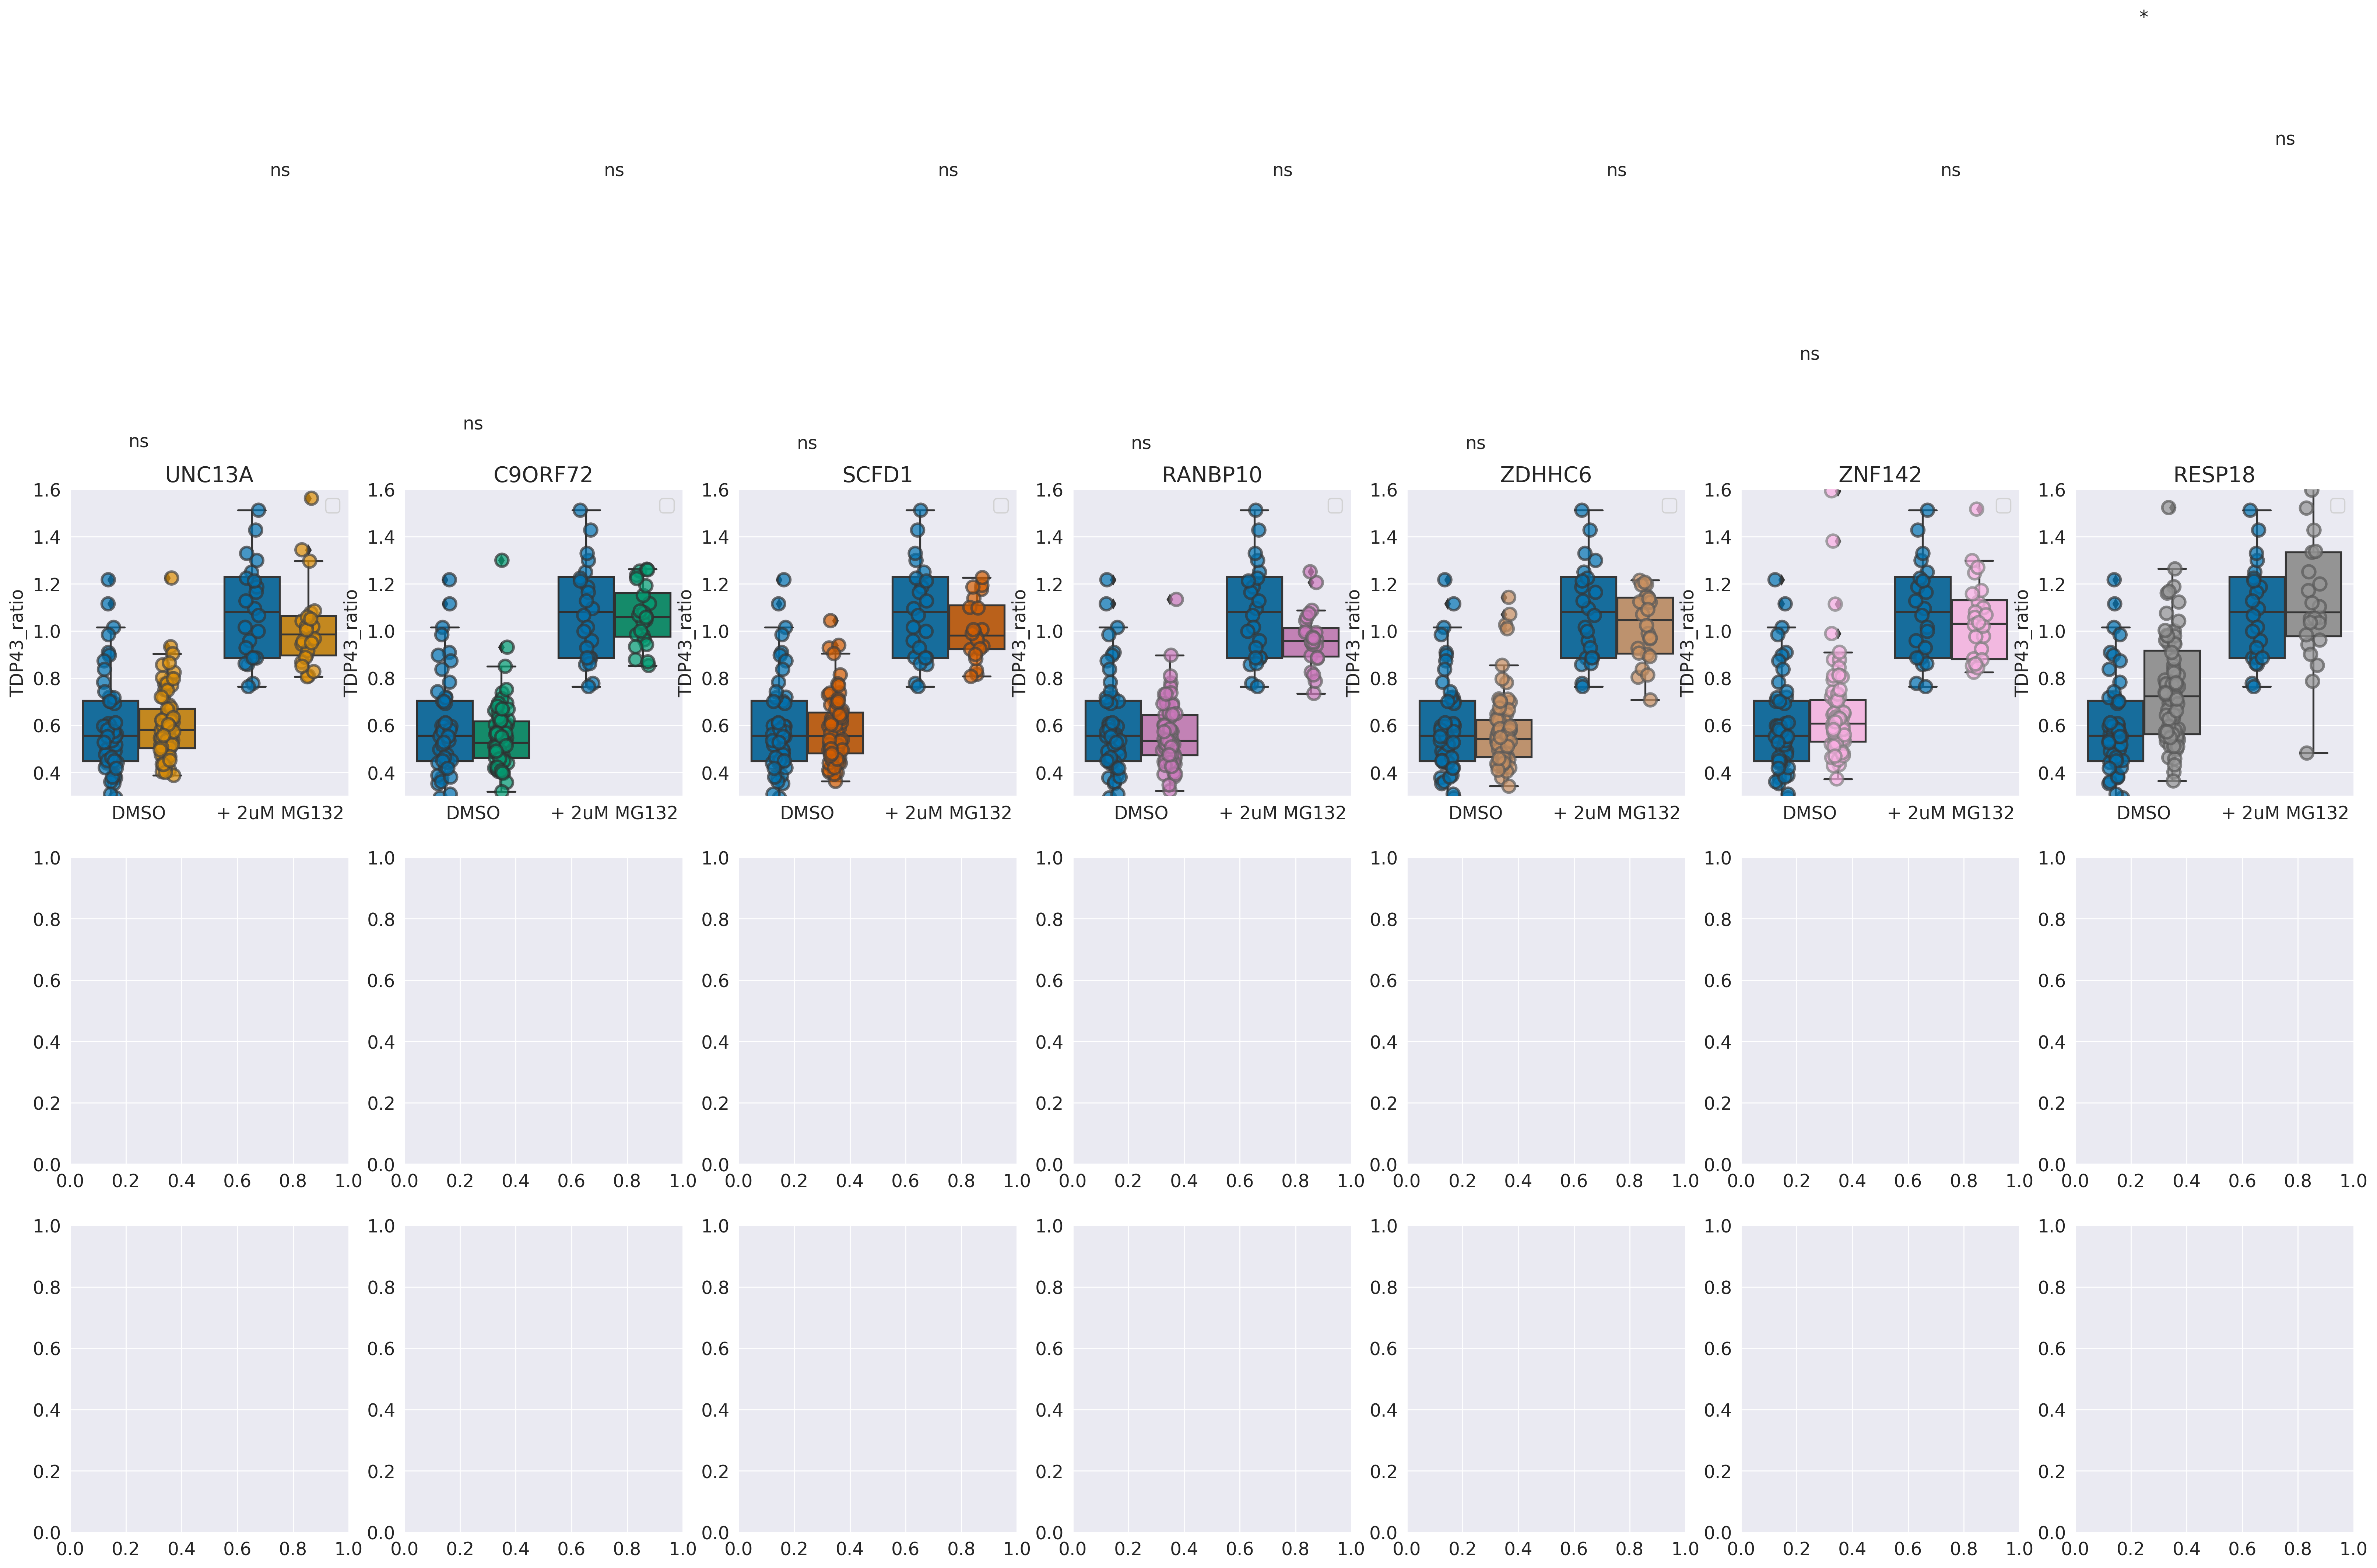

In [15]:
fig, axs = plt.subplots(3, len(crispr_mutants))
# pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
for i_crispr, crispr in enumerate(crispr_mutants):

    data = ratio_data.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')
    hue = 'crispr'
    x = 'concentration'
    y = 'TDP43_ratio'
    ax = axs[i_exp,i_crispr]
    crispr_color = sns.color_palette('colorblind')[i_crispr+1]
    hue_order = ['NT', crispr]
    sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color])
    sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
    ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
    ax.set_xlabel('')
    ax.legend([])
    ax.set_title(crispr)

    pairs = [(('0', neg_con), ('0', crispr)), ((concentration, neg_con), (concentration, crispr))]
    annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
    annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
    annot.apply_test(num_comparisons=len(crispr_mutants)*2)
    ax, test_results = annot.annotate(line_offset_to_group=0.2)
    ax.set_ylim(ylims[i_exp])

In [5]:
nuclei_data = pd.read_csv('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1/2023-03-27_cellpose_tdp-43/2023-03-27_cellpose_tdp-43nuclei.csv')
soma_data = pd.read_csv('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1/2023-03-27_cellpose_tdp-43/2023-03-27_cellpose_tdp-43cytoplasm_outlines.csv')

In [12]:
nuclei_data['ImageNumber'].unique()[100:101].shape

(1,)

In [19]:
# def reindex_nuclei(soma_data, nuclei_data)
nucleus_selection = np.zeros(soma_data.shape[0])
j_soma = 0
for img_number in nuclei_data['ImageNumber'].unique()[100:101]:

    nd = nuclei_data.query('ImageNumber==@img_number')
    sd = soma_data.query('ImageNumber==@img_number')

    for i_soma, sd_row in sd.iterrows():
        soma_bb = get_bounding_box(sd_row)

        # Get centroid distances to sd soma for all nucleli
        nuclei_dist = np.sqrt(
            (sd_row['AreaShape_Center_X'] - nd['AreaShape_Center_X']) ** 2 + \
            (sd_row['AreaShape_Center_Y'] - nd['AreaShape_Center_Y']) ** 2  
        )
        # Get five closest nuclei
        closet_nuclei = nd.iloc[np.argsort(nuclei_dist)[:5]]

        ion_list = np.zeros(closet_nuclei.shape[0])
        i_nucleus = 0
        for j_nucleus, cn_row in closet_nuclei.iterrows():
            nucleus_bb = get_bounding_box(cn_row)

            ion_list[i_nucleus] = get_ion(soma_bb, nucleus_bb)
            i_nucleus += 1

        print(ion_list)
        best_nucleus = np.array(ion_list).argmax()
        # nucleus_selection[j_soma] = closet_nuclei.index[best_nucleus]
        nucleus_selection[j_soma] = closet_nuclei.index[0]
        j_soma += 1

# soma_data = soma_data.reindex(soma_reindex)
# soma_data.index = np.arange(soma_data.shape[0])
nuclei_data = nuclei_data.reindex(nucleus_selection)
nuclei_data.index = np.arange(nuclei_data.shape[0])

/tmp/ipykernel_2197/547745084.py:18: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  closet_nuclei = nd.iloc[np.argsort(nuclei_dist)[:5]]


[0. 0. 0. 0. 0.]
[0.76190476 0.         0.         0.         0.        ]
[0.42206897 0.11034483 0.         0.         0.        ]
[0.61363636 0.19090909 0.         0.         0.        ]
[0.50980392 0.03186275 0.         0.         0.        ]
[0.63157895 0.01403509 0.         0.         0.        ]
[0.74285714 0.         0.         0.         0.        ]
[0.44720497 0.         0.         0.         0.        ]
[0.58352403 0.         0.         0.         0.        ]
[0.57826087 0.         0.         0.         0.        ]
[0.12670565 0.         0.         0.         0.        ]
[0.4954955  0.         0.02702703 0.         0.        ]
[0.62030075 0.         0.11278195 0.         0.        ]
[0.69545455 0.23636364 0.04090909 0.         0.        ]
[0.70914127 0.         0.         0.         0.        ]
[0.36090226 0.06766917 0.         0.         0.        ]
[0.65217391 0.14492754 0.         0.         0.        ]
[0.67460317 0.         0.         0.         0.        ]
[0.53021442 0.

In [20]:
nuclei_data

,ImageNumber,ObjectNumber,FileName_DAPI,FileName_MAP2,FileName_TDP43,FileName_nuclei_outlines,FileName_soma_outlines,PathName_DAPI,PathName_MAP2,PathName_TDP43,...,Location_MaxIntensity_X_DAPI_corrected,Location_MaxIntensity_X_MAP2_corrected,Location_MaxIntensity_X_TDP43_corrected,Location_MaxIntensity_Y_DAPI_corrected,Location_MaxIntensity_Y_MAP2_corrected,Location_MaxIntensity_Y_TDP43_corrected,Location_MaxIntensity_Z_DAPI_corrected,Location_MaxIntensity_Z_MAP2_corrected,Location_MaxIntensity_Z_TDP43_corrected,Number_Object_Number
0,101,15,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch1sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,783.0,785.0,783.0,43.0,46.0,55.0,0.0,0.0,0.0,15
1,101,6,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch1sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,839.0,837.0,836.0,29.0,22.0,36.0,0.0,0.0,0.0,6
2,101,13,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch1sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,565.0,563.0,568.0,42.0,50.0,48.0,0.0,0.0,0.0,13
3,101,11,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch1sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,606.0,610.0,608.0,39.0,37.0,37.0,0.0,0.0,0.0,11
4,101,12,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch1sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,r02c07f05p01-ch3sk1fk1fl1.tiff,r02c07f05p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,583.0,581.0,575.0,38.0,37.0,45.0,0.0,0.0,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94310,1,1,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1048.0,1050.0,1044.0,15.0,19.0,19.0,0.0,0.0,0.0,1
94311,1,1,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1048.0,1050.0,1044.0,15.0,19.0,19.0,0.0,0.0,0.0,1
94312,1,1,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1048.0,1050.0,1044.0,15.0,19.0,19.0,0.0,0.0,0.0,1
94313,1,1,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1048.0,1050.0,1044.0,15.0,19.0,19.0,0.0,0.0,0.0,1


In [10]:
ion_list

array([0., 0., 0., 0., 0.])

In [84]:
soma_bb

[889, 1054, 912, 1074]

In [85]:
nucleus_bb

[856, 977, 873, 996]

In [90]:
pd.DataFrame(nucleus_selection).iloc[120:150]

,0
120,20137.0
121,20141.0
122,20132.0
123,20143.0
124,20145.0
125,20151.0
126,20146.0
127,20153.0
128,20158.0
129,20159.0


In [67]:
pd.DataFrame(nucleus_selection[120:150])

,0
0,20137.0
1,20141.0
2,19887.0
3,20143.0
4,20145.0
5,20151.0
6,20146.0
7,20153.0
8,20158.0
9,20159.0


In [91]:
np.unique(nucleus_selection).shape

(135,)

In [73]:
nucleus_selection.shape

(94315,)

In [28]:
x = sd.loc[7246, 'AreaShape_Center_X']
y = sd.loc[7246, 'AreaShape_Center_Y']

dis = np.sqrt((x - nd['AreaShape_Center_X']) ** 2 + (y - nd['AreaShape_Center_Y']) ** 2)

In [66]:
# def reindex_nuclei(soma_data, nuclei_data)
nucleus_selection = np.zeros(soma_data.shape[0])
j_soma = 0
for img_number in nuclei_data['ImageNumber'].unique()[100:101]:

    nd = nuclei_data.query('ImageNumber==@img_number')
    sd = soma_data.query('ImageNumber==@img_number')

    for i_soma, sd_row in sd.iterrows():
        soma_bb = get_bounding_box(sd_row)
    
        ion_list = np.zeros(nd.shape[0])
        i_nucleus = 0
        for j_nucleus, nd_row in nd.iterrows():
            nucleus_bb = get_bounding_box(nd_row)

            ion_list[i_nucleus] = get_ion(soma_bb, nucleus_bb)
            i_nucleus += 1

        best_nucleus = np.array(ion_list).argmax()
        nucleus_selection[j_soma] = nd.index[best_nucleus]
        j_soma += 1

# soma_data = soma_data.reindex(soma_reindex)
# soma_data.index = np.arange(soma_data.shape[0])

/tmp/ipykernel_2780/830816011.py:14: RuntimeWarning: invalid value encountered in long_scalars
  ion = (nucleus_img * soma_img).sum() / (nucleus_img).sum()


In [9]:
dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
    Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
    Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/')]

[x for x in enumerate([dirs[0]])]

[(0,
  PosixPath('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'))]

/tmp/ipykernel_2197/2621823222.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r = r.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


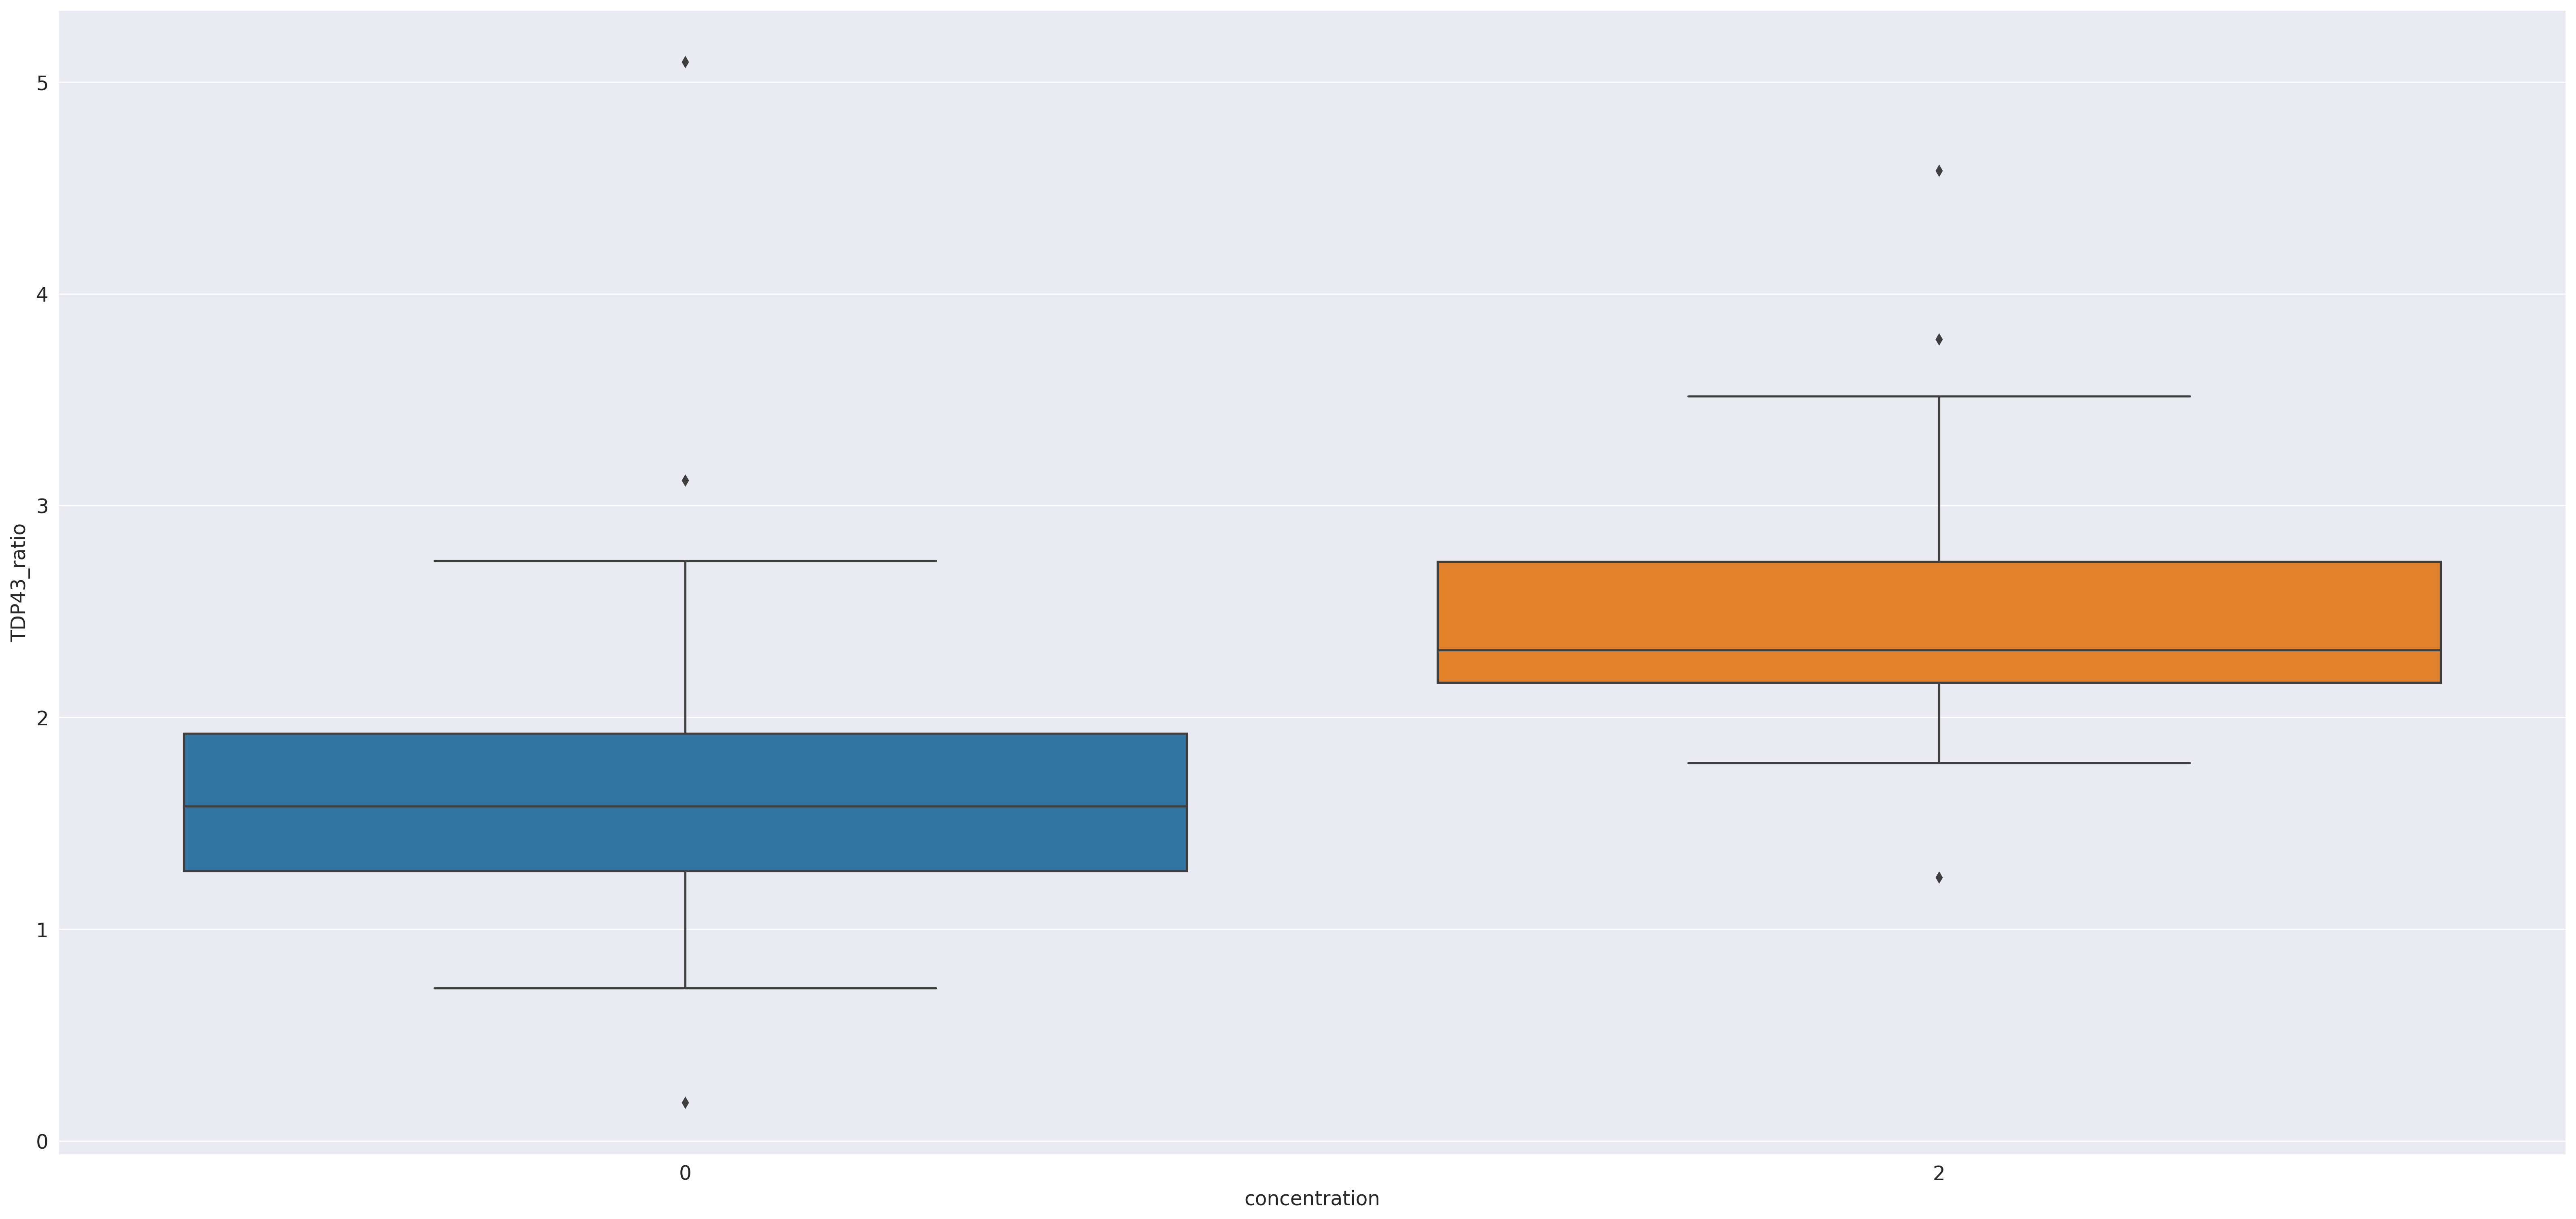

In [63]:
drop_inds = plate.soma_data['AreaShape_EquivalentDiameter'] < 20
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
r = ratio_data.drop(ratio_data[drop_inds].index)
r = r.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
r = r.reset_index()
r = r.query('crispr==@neg_con and concentration in ["0", "2"]')
# sns.histplot(r.query('concentration=="0"')['TDP43_ratio'])
# sns.histplot(r.query('concentration=="2"')['TDP43_ratio'])
# plt.xlim([-5, 5])
sns.boxplot(data=r, y='TDP43_ratio', x='concentration')

/tmp/ipykernel_2197/2241410435.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r = r.drop(r[drop_inds].index)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_UNC13A vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:3.914e-02 t=-2.992e+00
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:5.414e-77 t=1.893e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_C9ORF72 vs. 2_NT: t-test independent samples with Bonferroni correction, P_val:1.269e-02 t=-3.321e+00
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:3.392e-02 t=3.034e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_SCFD1 vs. 2_NT: t-test independent samples 

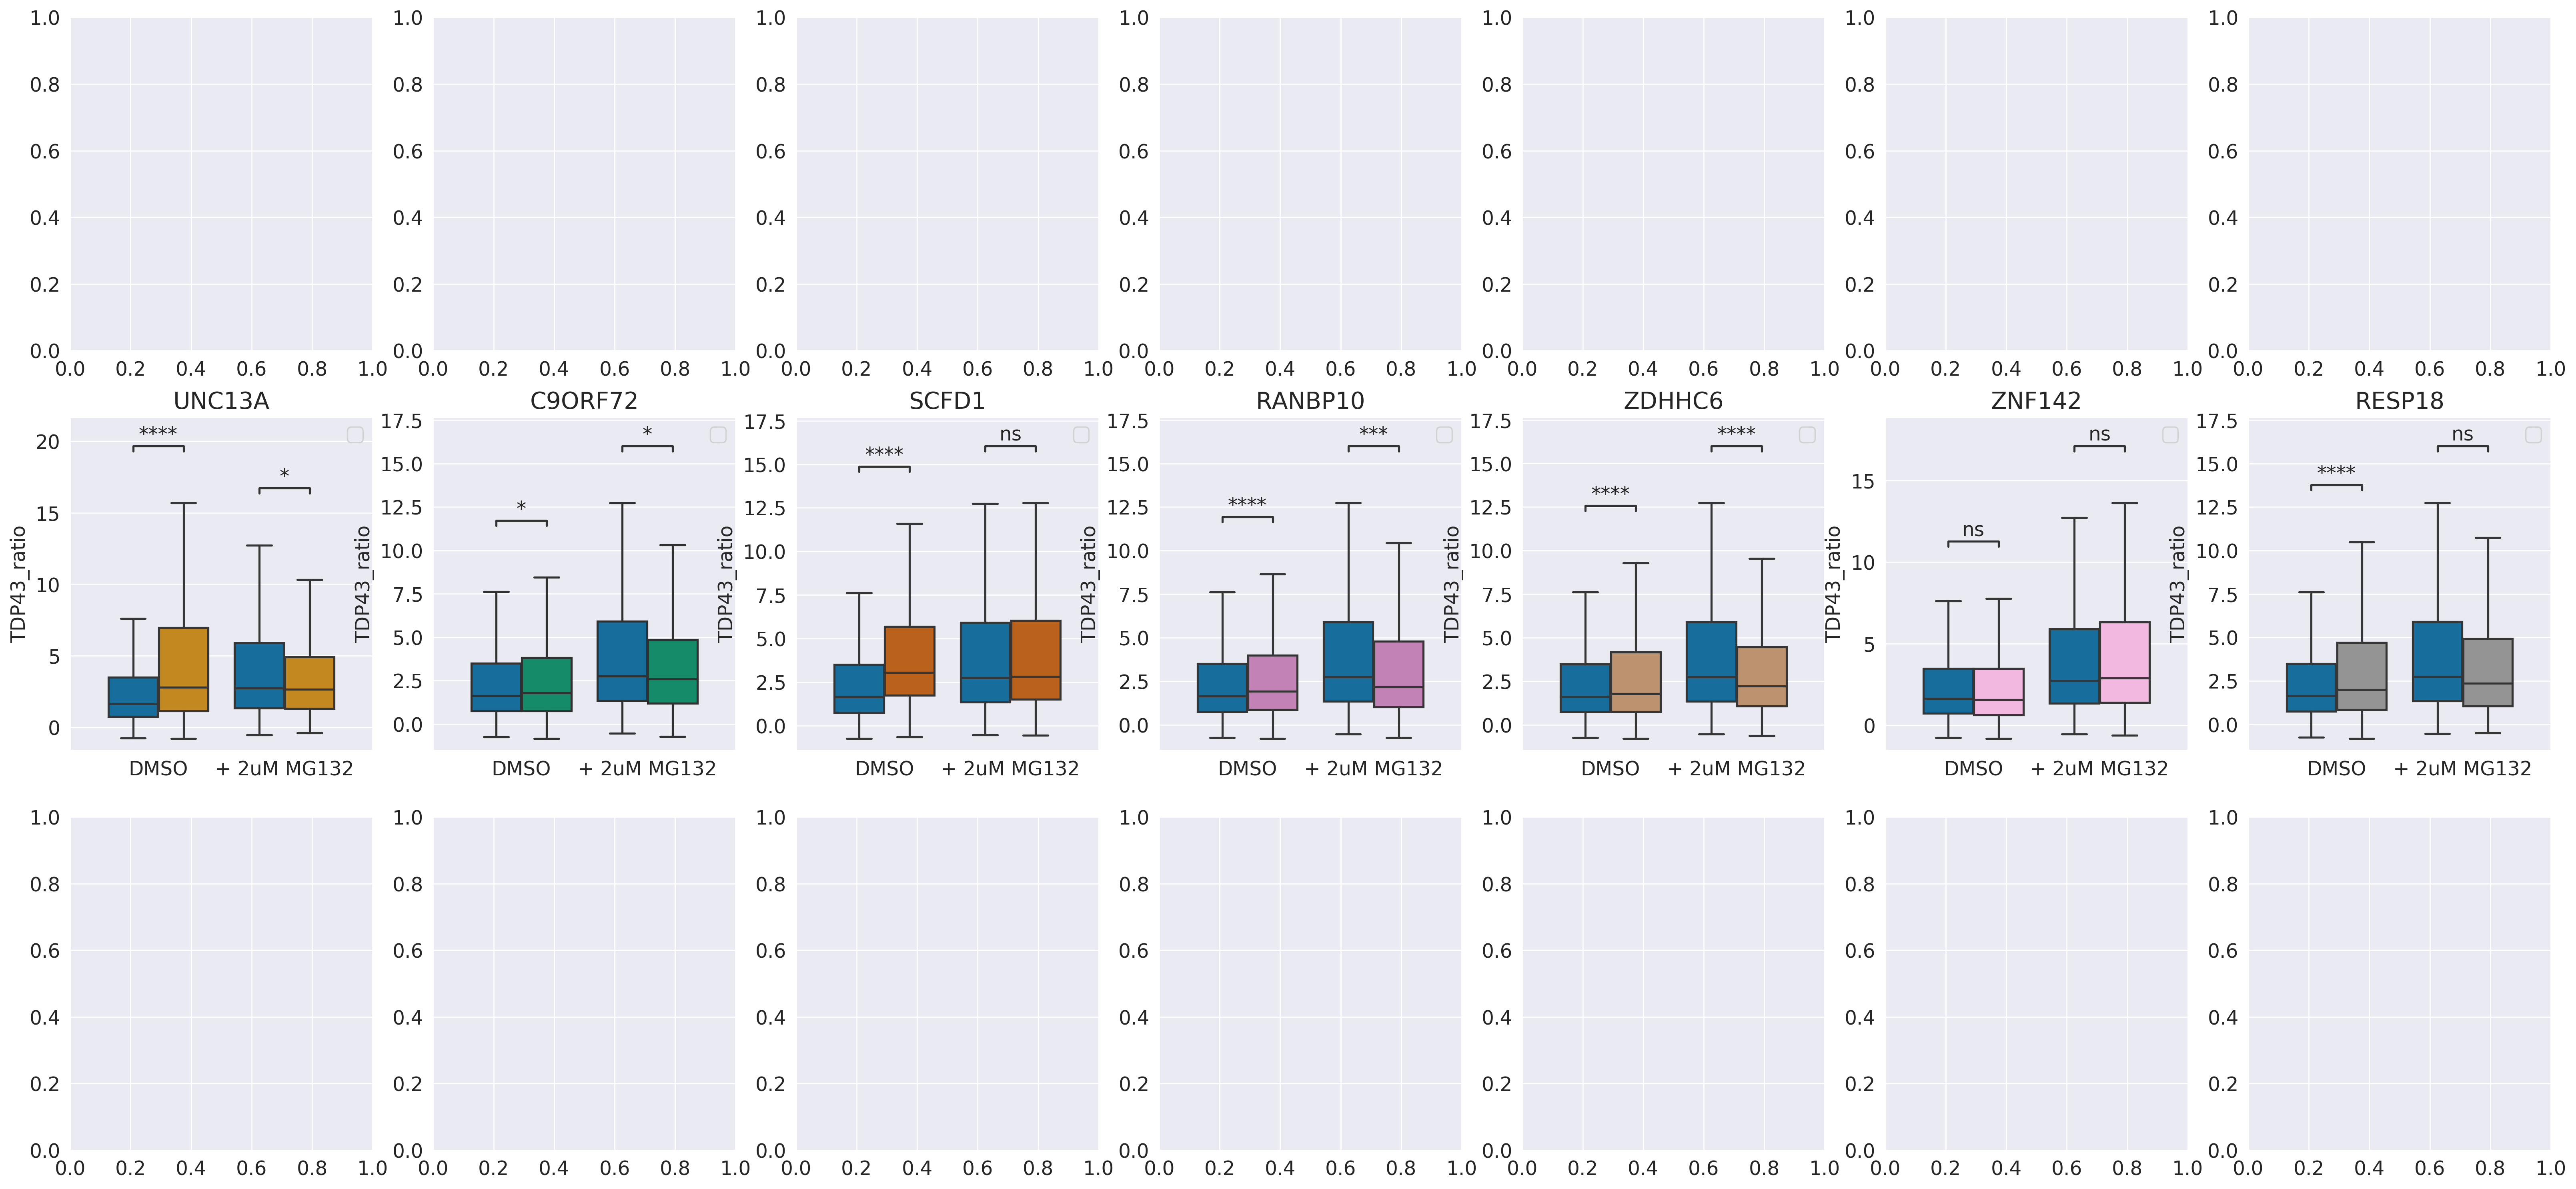

In [75]:
fig, axs = plt.subplots(3, len(crispr_mutants))
# pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
drop_inds = plate.soma_data['AreaShape_EquivalentDiameter'] < 20
r = ratio_data.drop(ratio_data[drop_inds].index)
drop_inds = plate.soma_data['AreaShape_EquivalentDiameter'] > 42
r = r.drop(r[drop_inds].index)
# r = r.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
# r = r.reset_index()
for i_crispr, crispr in enumerate(crispr_mutants):

    data = r.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')
    hue = 'crispr'
    x = 'concentration'
    y = 'TDP43_ratio'
    ax = axs[i_exp,i_crispr]
    crispr_color = sns.color_palette('colorblind')[i_crispr+1]
    hue_order = ['NT', crispr]
    sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color], showfliers=False)
    # sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
    ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
    ax.set_xlabel('')
    ax.legend([])
    ax.set_title(crispr)

    pairs = [(('0', neg_con), ('0', crispr)), ((concentration, neg_con), (concentration, crispr))]
    annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
    annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
    annot.apply_test(num_comparisons=len(crispr_mutants)*2)
    ax, test_results = annot.annotate(line_offset_to_group=0.2)
    # ax.set_ylim(ylims[i_exp])

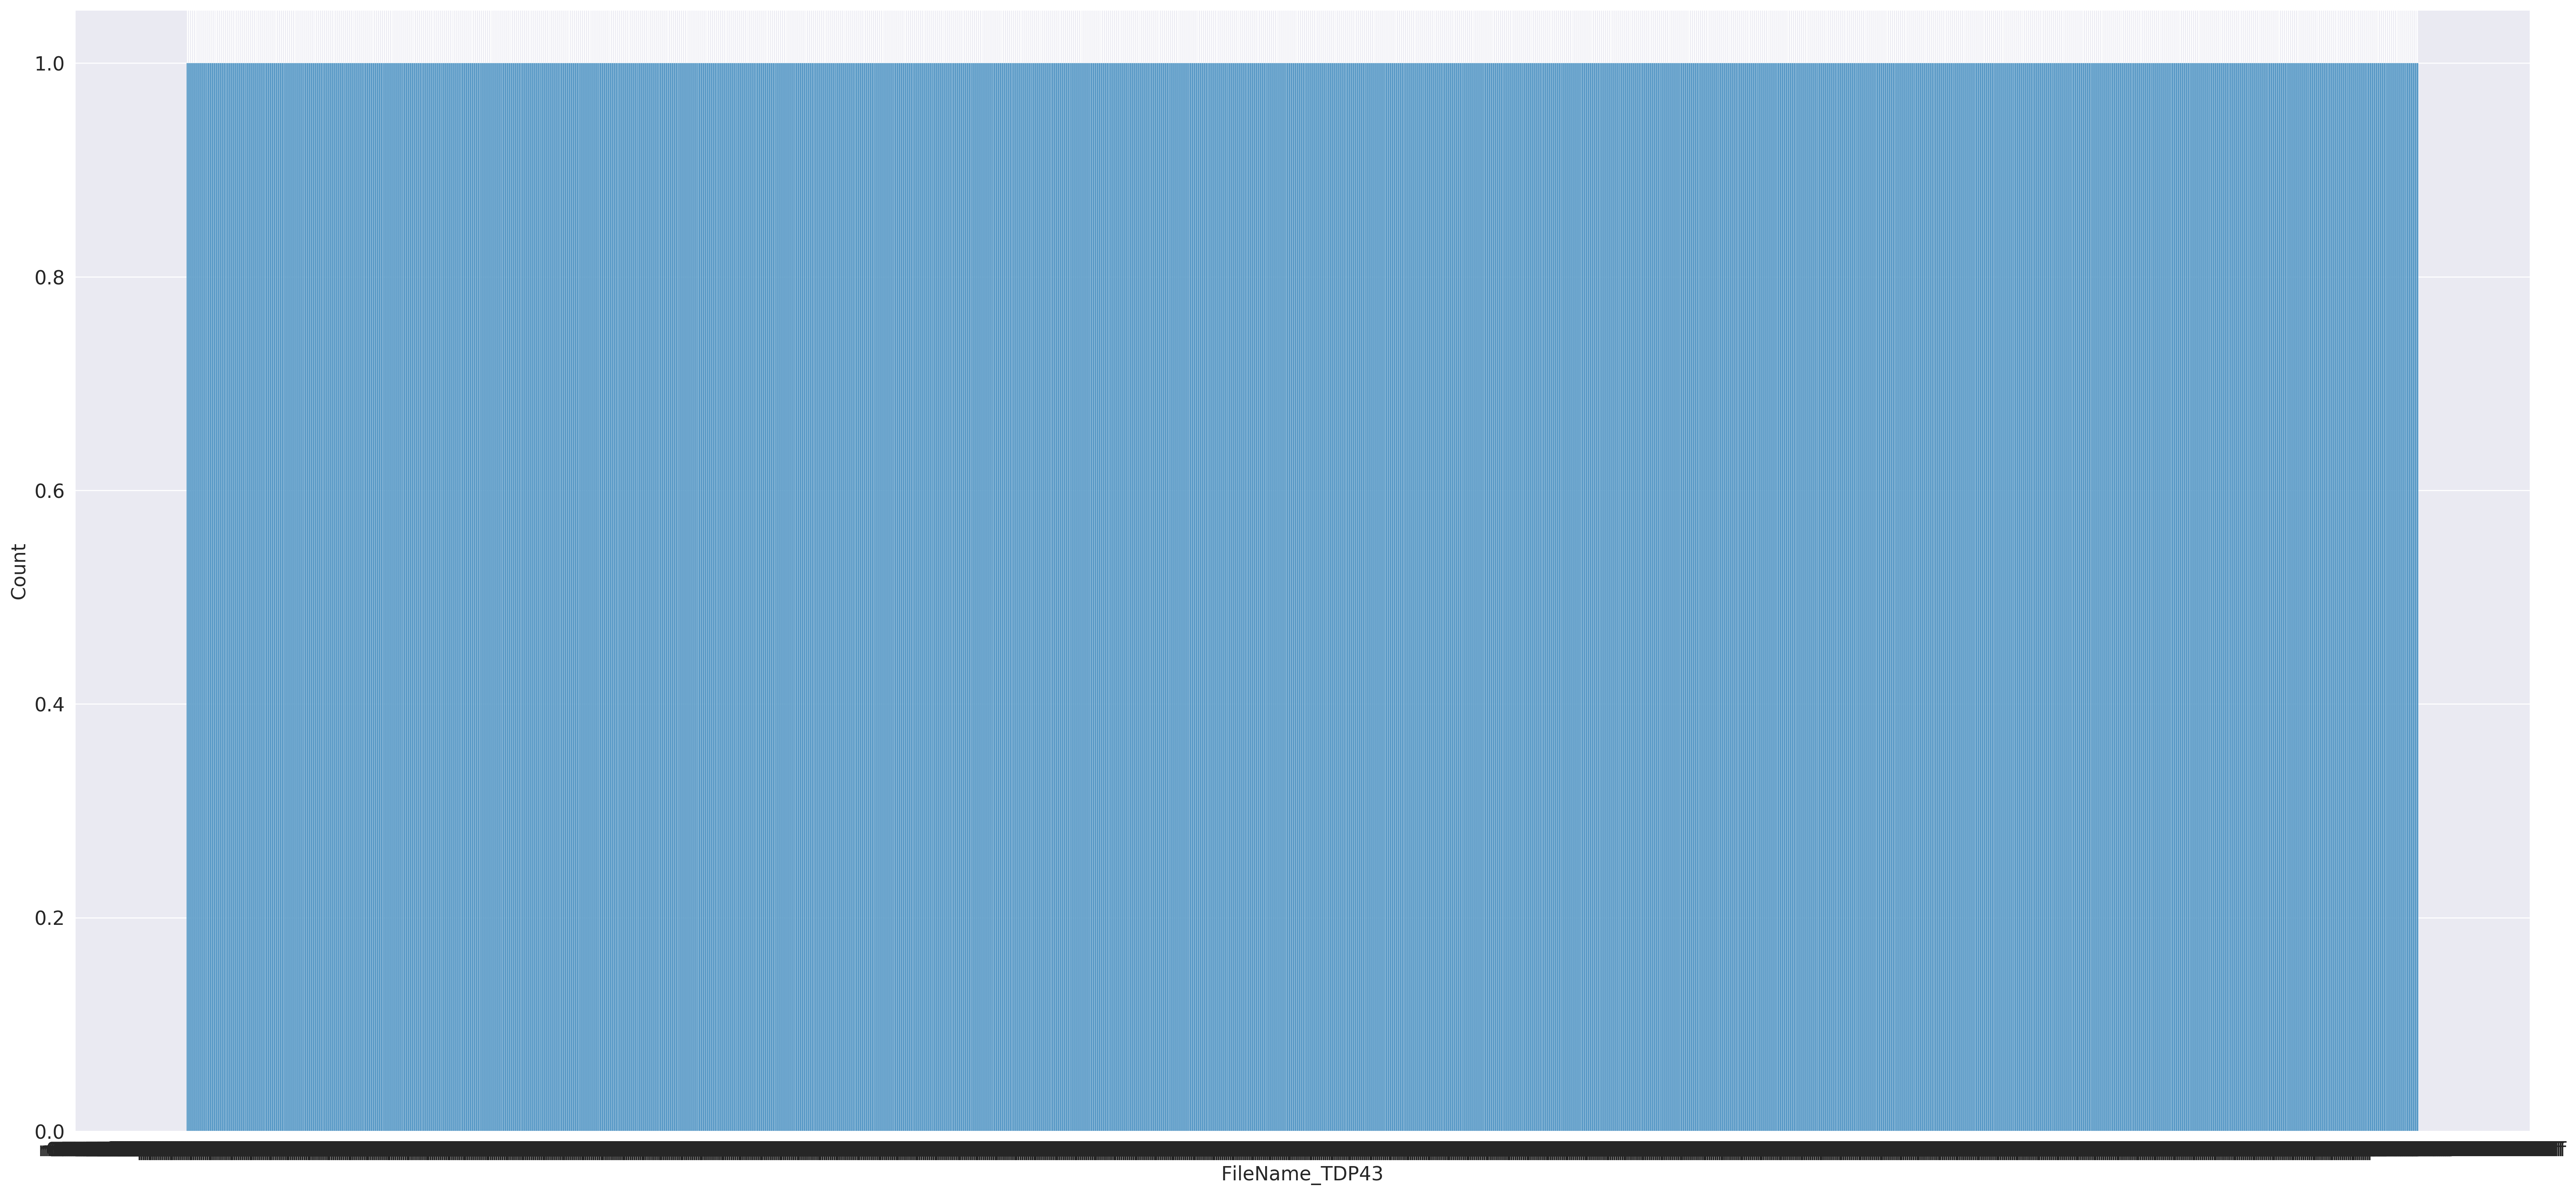

In [19]:
sns.histplot(ratio_data['FileName_TDP43'])

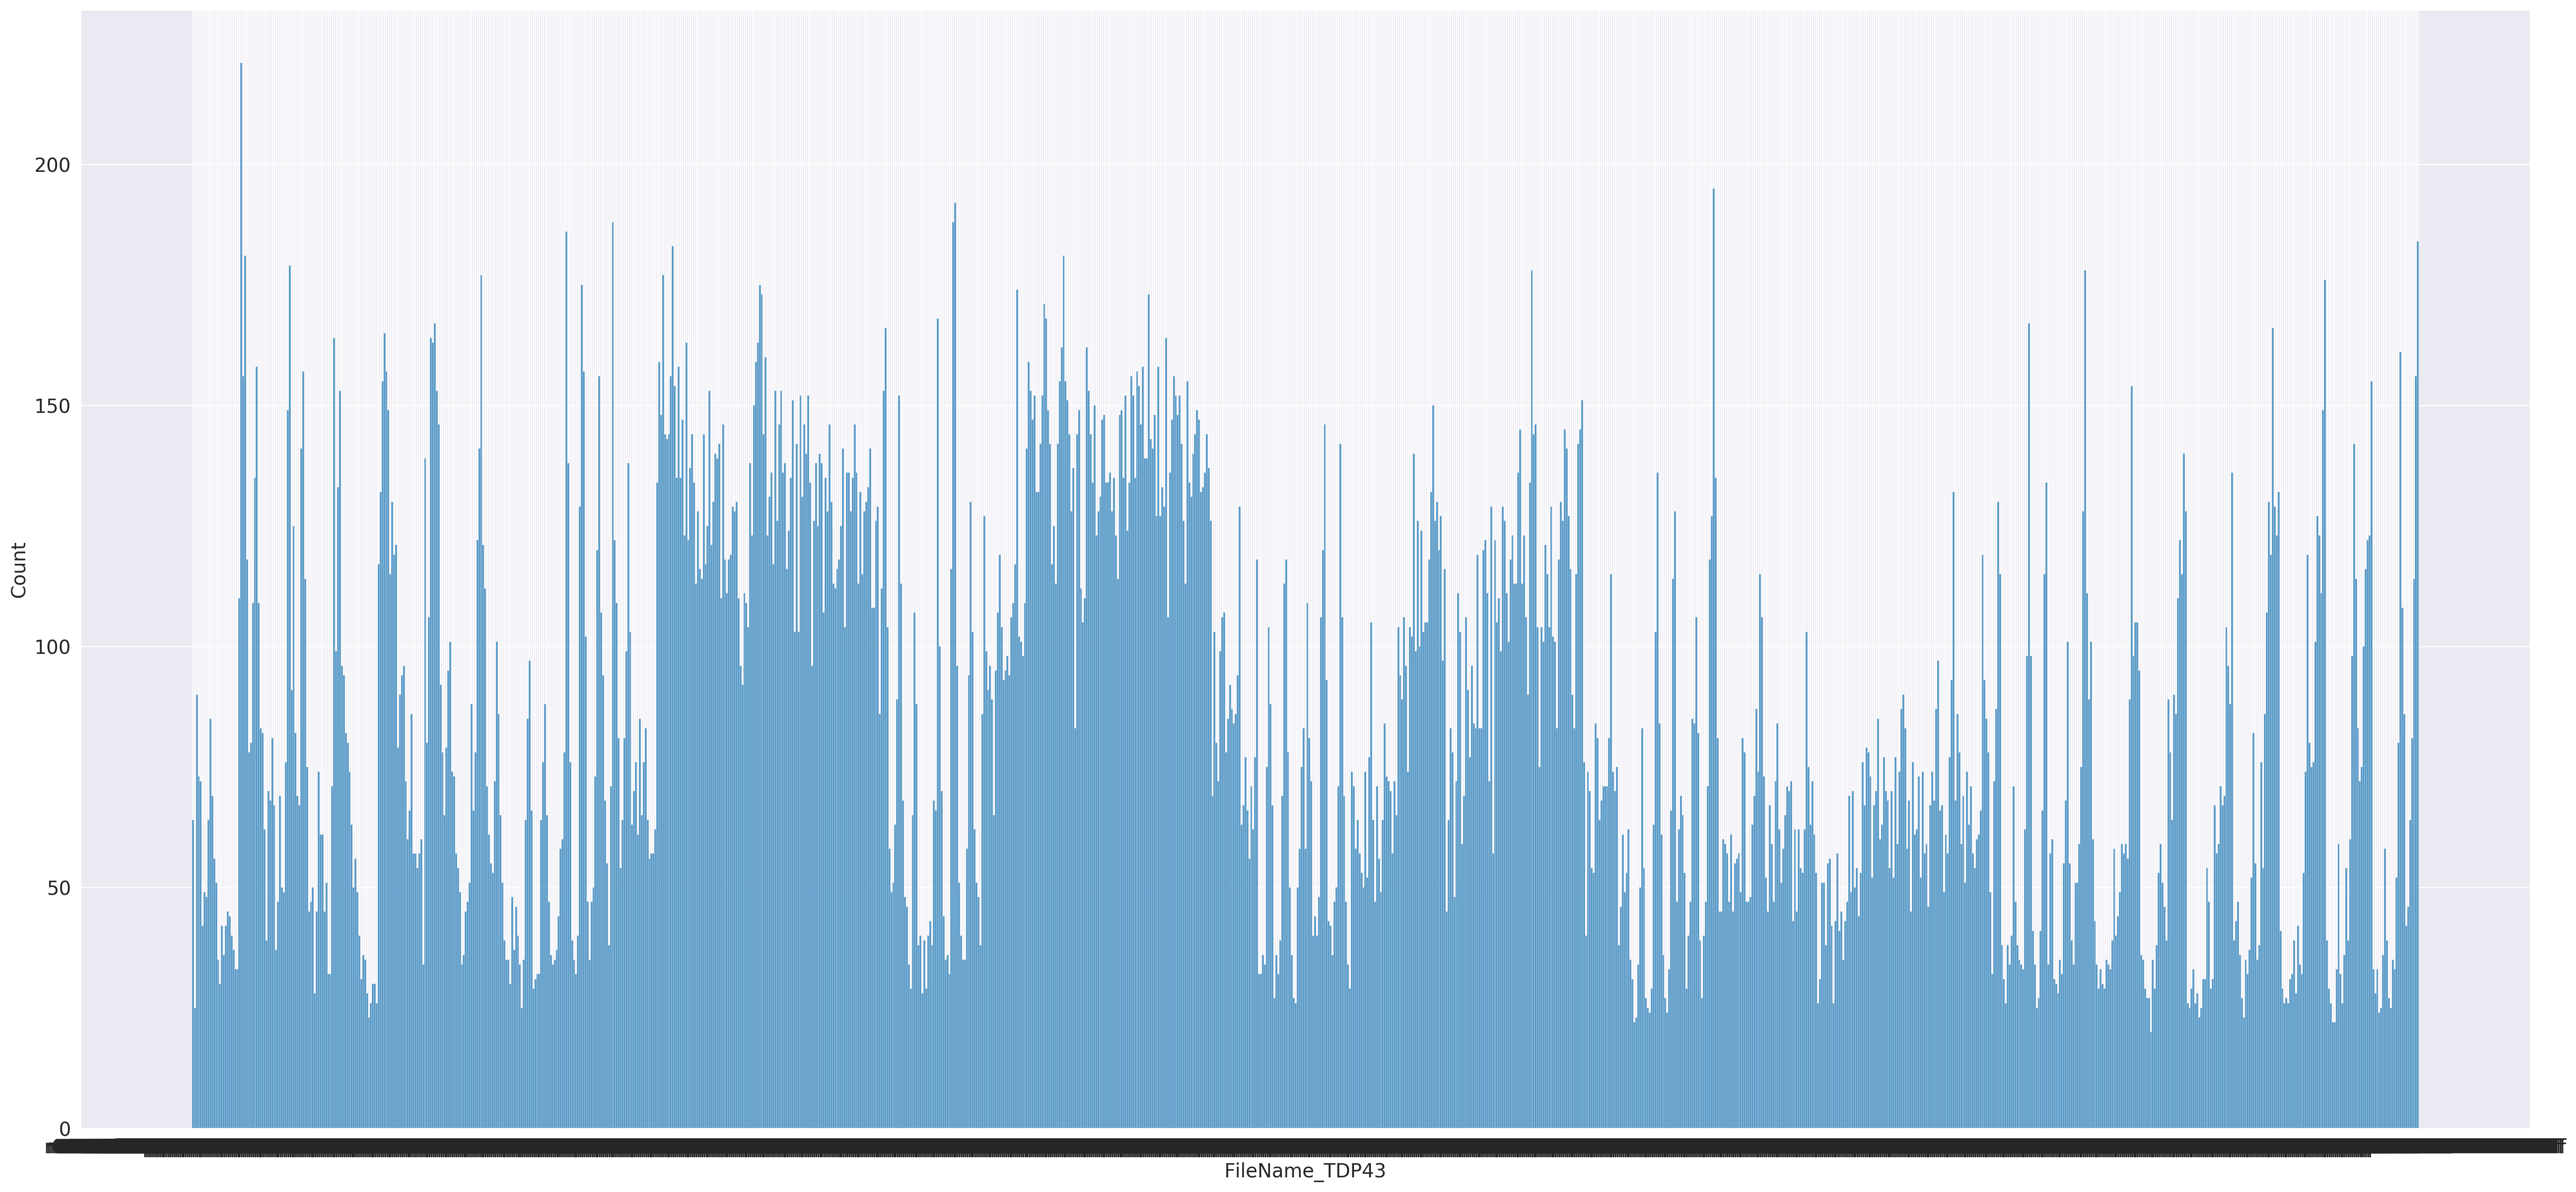

In [72]:
sns.histplot(ratio_data['FileName_TDP43'])

In [28]:
plate = Plate(data_dir, analysis_name)
plate.reindex_nuclei()
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
# ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
ratio_data = ratio_data.reset_index()

,FileName_TDP43,crispr,treatment,concentration,row,col,TDP43_nucleus,TDP43_cytoplasm,TDP43_ratio
0,r02c03f01p01-ch2sk1fk1fl1.tiff,empty,empty,empty,2.0,3.0,0.010196,0.012251,1.244318
1,r02c03f02p01-ch2sk1fk1fl1.tiff,empty,empty,empty,2.0,3.0,0.010030,-0.003865,-0.322260
2,r02c03f03p01-ch2sk1fk1fl1.tiff,empty,empty,empty,2.0,3.0,0.009588,-0.217885,-24.533997
3,r02c03f04p01-ch2sk1fk1fl1.tiff,empty,empty,empty,2.0,3.0,0.009105,0.010040,1.105630
4,r02c03f05p01-ch2sk1fk1fl1.tiff,empty,empty,empty,2.0,3.0,0.009185,0.009920,1.080735
...,...,...,...,...,...,...,...,...,...
1145,r07c10f20p01-ch2sk1fk1fl1.tiff,RESP18,MG132,0.25,7.0,10.0,0.080439,0.064259,1.204828
1146,r07c10f21p01-ch2sk1fk1fl1.tiff,RESP18,MG132,0.25,7.0,10.0,0.086621,-0.017859,-0.762301
1147,r07c10f22p01-ch2sk1fk1fl1.tiff,RESP18,MG132,0.25,7.0,10.0,0.081873,-0.039345,-3.748473
1148,r07c10f23p01-ch2sk1fk1fl1.tiff,RESP18,MG132,0.25,7.0,10.0,0.094391,0.084047,1.304290


In [22]:
len(nucleus_selection)

18

In [23]:
soma_data

,ImageNumber,ObjectNumber,FileName_DAPI,FileName_MAP2,FileName_TDP43,FileName_nuclei_outlines,FileName_soma_outlines,PathName_DAPI,PathName_MAP2,PathName_TDP43,...,RadialDistribution_ZernikePhase_TDP43_corrected_8_0,RadialDistribution_ZernikePhase_TDP43_corrected_8_2,RadialDistribution_ZernikePhase_TDP43_corrected_8_4,RadialDistribution_ZernikePhase_TDP43_corrected_8_6,RadialDistribution_ZernikePhase_TDP43_corrected_8_8,RadialDistribution_ZernikePhase_TDP43_corrected_9_1,RadialDistribution_ZernikePhase_TDP43_corrected_9_3,RadialDistribution_ZernikePhase_TDP43_corrected_9_5,RadialDistribution_ZernikePhase_TDP43_corrected_9_7,RadialDistribution_ZernikePhase_TDP43_corrected_9_9
0,1,1,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,2.781264,-2.802162,-1.873104,1.764401,-0.288365,-2.956407,-0.818034,-2.051160,-0.987605
1,1,2,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.633591,1.855562,-0.278070,2.130811,-2.478456,1.799989,2.623989,3.096573,-2.871889
2,1,3,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.725774,1.227060,-0.457644,-0.746891,-2.694573,-0.603346,-0.089162,-2.619883,1.667113
3,1,4,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.155172,2.473096,0.591089,1.935807,2.432233,1.609436,-1.606842,0.329691,0.142361
4,1,5,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.068278,-1.849844,-0.544067,1.048856,1.294383,-2.472344,3.019819,0.318530,-1.589541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94310,1152,64,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-1.355497,2.216524,-2.953113,-0.876973,1.906770,0.133076,2.576055,0.570569,2.773079
94311,1152,65,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,-1.570796,-2.991288,2.006046,0.683222,2.084406,3.065021,1.734117,1.795677,-2.592216,-2.016938
94312,1152,66,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,2.587984,1.42

In [7]:
soma_data

,ImageNumber,ObjectNumber,FileName_DAPI,FileName_MAP2,FileName_TDP43,FileName_nuclei_outlines,FileName_soma_outlines,PathName_DAPI,PathName_MAP2,PathName_TDP43,...,RadialDistribution_ZernikePhase_TDP43_corrected_8_0,RadialDistribution_ZernikePhase_TDP43_corrected_8_2,RadialDistribution_ZernikePhase_TDP43_corrected_8_4,RadialDistribution_ZernikePhase_TDP43_corrected_8_6,RadialDistribution_ZernikePhase_TDP43_corrected_8_8,RadialDistribution_ZernikePhase_TDP43_corrected_9_1,RadialDistribution_ZernikePhase_TDP43_corrected_9_3,RadialDistribution_ZernikePhase_TDP43_corrected_9_5,RadialDistribution_ZernikePhase_TDP43_corrected_9_7,RadialDistribution_ZernikePhase_TDP43_corrected_9_9
0,1,1,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,2.781264,-2.802162,-1.873104,1.764401,-0.288365,-2.956407,-0.818034,-2.051160,-0.987605
1,1,2,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.633591,1.855562,-0.278070,2.130811,-2.478456,1.799989,2.623989,3.096573,-2.871889
2,1,3,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.725774,1.227060,-0.457644,-0.746891,-2.694573,-0.603346,-0.089162,-2.619883,1.667113
3,1,4,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.155172,2.473096,0.591089,1.935807,2.432233,1.609436,-1.606842,0.329691,0.142361
4,1,5,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.068278,-1.849844,-0.544067,1.048856,1.294383,-2.472344,3.019819,0.318530,-1.589541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94310,1152,64,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-1.355497,2.216524,-2.953113,-0.876973,1.906770,0.133076,2.576055,0.570569,2.773079
94311,1152,65,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,-1.570796,-2.991288,2.006046,0.683222,2.084406,3.065021,1.734117,1.795677,-2.592216,-2.016938
94312,1152,66,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,2.587984,1.42